# 数据管道DataSet

对于小数据集直接读入内存，效率高；

对于大数据集，无法一次性读入内存，通常需要在训练的过程中分批次读取；

使用tf.DataSet　API可以方便构建输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot as plt

## 一．构建数据管道

可以从numpy.array,pandas,generator,csv,txt,文件路径，tfrecords文件等方式构建数据管道．

其中通过Numpy array,Pandas DataFrame ，文件路径构造是数据管道最常用的方法．

通过tfrecoreds文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecoreds文件，读取后在解析成tf.Example.

但tfrecoreds文件的优点是压缩后文件较小，便于网络传输，加载速度较快．

### 1.从numpy数组创建数据管道

In [2]:
iris = datasets.load_iris()

ds1 = tf.data.Dataset.from_tensor_slices((iris['data'],iris['target']))
for features,label in ds1.take(5):
    print(features,label)

tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


### 2.从pandas DataFrame构建数据管道

In [4]:
dfiris = pd.DataFrame(iris['data'],columns=iris.feature_names)
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict('list'),iris['target']))
for features,label in ds2.take(5):
    print(features,label)

{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float

### 3.从Python　generator构建数据管道

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
##　定义一个从文件中读取图片的generator
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './../data/cifar2/test/',
    target_size=(32,32),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [6]:
classdict = image_generator.class_indices
print(classdict)

{'airplane': 0, 'automobile': 1}


In [9]:
def generator():
    for features,label in image_generator:
        yield (features,label)
        
ds3 = tf.data.Dataset.from_generator(generator=generator,output_types=(tf.float32,tf.int32))

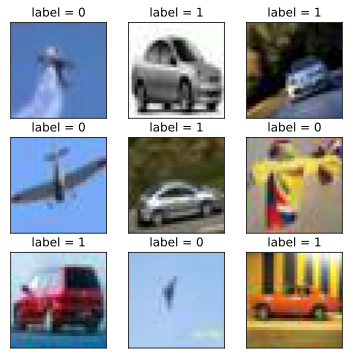

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6))
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title('label = %d'%(label))
    ax.set_xticks([]) ## 设置
    ax.set_yticks([])
plt.show()

### 4.从csv文件构建数据管道

In [13]:
ds4 = tf.data.experimental.make_csv_dataset(
    file_pattern = ['./../data/titanic/train.csv','./../data/titanic/test.csv'],
    batch_size=3,
    label_name='Survived',
    na_value='',
    num_epochs=1,
    ignore_errors=True
)
for data,labels in ds4.take(2):
    print(data,labels)

OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([403, 396, 651], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 3, 3], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Jussila, Miss. Mari Aina', b'Johansson, Mr. Erik',
       b'Mitkoff, Mr. Mito'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'female', b'male', b'male'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([21., 22.,  0.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'4137', b'350052', b'349221'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([9.825 , 7.7958, 7.8958], dtype=float32)>), ('Cabin', <tf.Tensor: shape=(3,), dtype=string, numpy=

### 5.从文本文件构建数据管道

In [14]:
ds5 = tf.data.TextLineDataset(filenames=['./../data/titanic/train.csv','./../data/titanic/test.csv']).skip(1) ## 略去首行
for line in ds5.take(5):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,,S', shape=(), dtype=string)


### 6.从文件路径构建数据管道

In [16]:
ds6 = tf.data.Dataset.list_files('./../data/cifar2/train/*/*.jpg')
for file in ds6.take(5):
    print(file)

tf.Tensor(b'./../data/cifar2/train/automobile/3791.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/airplane/1150.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/airplane/4091.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/automobile/988.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/automobile/4773.jpg', shape=(), dtype=string)


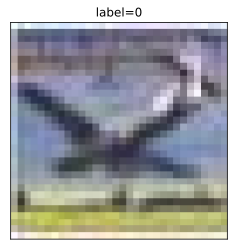

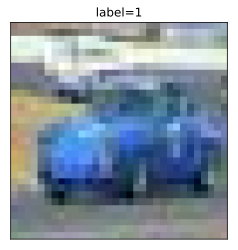

In [17]:
def load_image(img_path,size=(32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,'.*/automobile/.*') else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)
    return (img,label)
for i, (img,label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img/255.).numpy())
    plt.title('label=%d'%label)
    plt.xticks([])
    plt.yticks([])

### 7.从tfrecords文件构建数据管道

通过tfrecoreds文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecoreds文件，读取后在解析成tf.Example.

In [18]:
import os
def create_tfrecords(inpath,outpath):
    '''
    inpath:原始文件路径
    outpath:TFRecord文件输出路径
    '''
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index,name in enumerate(dirs):
        class_path = os.path.join(inpath,name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path,image_name)
            img = tf.io.read_file(img_path)
            
            example = tf.train.Example(
                features = tf.train.Features(feature={
                    'label':tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                    'img_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.numpy()]))
                })
            )
            writer.write(example.SerializeToString())
    writer.close()
create_tfrecords('./../data/cifar2/test/','./../data/cifar2_test1.tfrecords/')

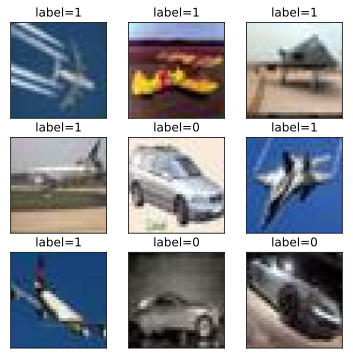

In [19]:
def parse_example(proto):
    desc = {'img_raw': tf.io.FixedLenFeature([],tf.string),'label':tf.io.FixedLenFeature([],tf.int64)}
    example = tf.io.parse_single_example(proto,desc)
    img = tf.image.decode_jpeg(example['img_raw'])
    img = tf.image.resize(img,(32,32))
    label = example['label']
    return (img,label)

ds7 = tf.data.TFRecordDataset('./../data/cifar2_test1.tfrecords').map(parse_example).shuffle(3000)
plt.figure(figsize=(6,6))
for i,(img,label) in enumerate(ds7.take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow((img/255.).numpy())
    ax.set_title('label=%d'%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 二．数据转换

Dataset数据结构应用非常灵活，因为它本质上是一个Sequece序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。

- map: 将转换函数映射到数据集每一个元素。
- flat_map: 将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。
- interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。
- filter: 过滤掉某些元素。
- zip: 将两个长度相同的Dataset横向铰合。
- concatenate: 将两个Dataset纵向连接。
- reduce: 执行归并操作。
- batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。
- padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。
- window :构建滑动窗口，返回Dataset of Dataset.
- shuffle: 数据顺序洗牌。
- repeat: 重复数据若干次，不带参数时，重复无数次。
- shard: 采样，从某个位置开始隔固定距离采样一个元素。
- take: 采样，从开始位置取前几个元素。